In [1]:
# imports
import networkx as nx
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
import time
from IPython.display import clear_output
import re
import copy

### Insert code here for importing the dataset

In [2]:
df = pd.read_csv('./covtype.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
Wilderness_Area1                      581012 non-null int64
Wilderness_Area2                      581012 non-null int64
Wilderness_Area3                      581012 non-null int64
Wilderness_Area4                      581012 non-null int64
Soil_Type1                            581012 non-

In [3]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


### Helper Methods

In [150]:
# main method used to igniting the forest
def ignite():
	burning_nodes = get_burning([n for n in g.nodes])
	for ignition_node in burning_nodes:
		neighbors = [n for n in g.neighbors(ignition_node)]
		if (len(neighbors) == 0):
			break
		for nb in neighbors:
			active_nb = get_burning([n for n in g.neighbors(nb)])

			s = 0
			for burning_nb in active_nb:
				w = g.get_edge_data(burning_nb, nb)['w']
				s = min(1,s+w)
				#s = s+w

			ths = g.nodes[nb]['threshold_switch']
			if (s >= ths and g[ignition_node][nb]['color'] != 'brown'):
				g.nodes[nb]['fire_state'] = 'burning'
				colors[nb-1] = 'orange'
				g.nodes[nb]['color'] = 'orange'
				g[ignition_node][nb]['color'] = 'orange'
	lifeline_update()
	life_edge_update()
	update_active_neighbors()
	for nd in [n for n in g.nodes]:
		if g.nodes[nd]['fire_state'] == 'burnt':
			g.nodes[nd]['color'] == 'brown'
			for item in [nb for nb in g.neighbors(nd)]:
				g[nd][item]['color'] = 'brown'

def update_active_neighbors():
	for itemm in [n for n in g.nodes()]:
		num = 0
		for item in [n for n in g.neighbors(itemm)]:
			if g.nodes[item]['fire_state'] == 'burning':
				num += 1
		g.nodes[itemm]['num_of_active_neighbors'] = num

# count how many are burning currently in the map
def count_burning(g):
	burning = 0
	for i in range(1,g.number_of_nodes()+1):
		if (g.nodes[i]['fire_state'] == 'burning'):
			burning += 1
	return burning

# count how many are burnt currently in the map
def count_burnt(g):
	burnt = 0
	for i in range(1,g.number_of_nodes()+1):
		if (g.nodes[i]['fire_state'] == 'burnt'):
			burnt += 1
	return burnt

# function used to draw the graph according to some parameters
def draw_graph(g, ns, node_colors, edge_colors, pos_dict, fs):
	nx.draw(g, node_size=ns, node_color=node_colors, edge_color=edge_colors, with_labels=wl, pos=pos_dict, font_size=fs)
	pos=nx.get_node_attributes(g,'pos')

# methods for updating life
def life_edge_update():
	for p in range(1,g.number_of_nodes()+1):
		for q in range(p+1,g.number_of_nodes()+1):
			if ((p,q) in edge_list):
				if (g[p][q]['color'] == 'orange'):
					g[p][q]['life'] -= 1
				if (g[p][q]['life'] < 0):
					g[p][q]['color'] == 'brown'
				
def lifeline_update():
	for node in [n for n in g.nodes()]:
		if (g.nodes[node]['fire_state'] == 'burning'):
			g.nodes[node]['life'] -= 1
		if (g.nodes[node]['life'] < 0):
			g.nodes[node]['fire_state'] = 'burnt'
			g.nodes[node]['color'] = 'brown'
			colors[node-1] = 'brown'

# given a list of nodes, return those nodes that are burning
def get_burning(lst):
# 	u = [node for node in lst if g.nodes[node]['fire_state'] == 'burning']
# 	return u
	burn_list = []
	for item in lst:
		if g.nodes[item]['fire_state'] == 'burning':
			burn_list.append(item)
	return burn_list

# compute euclidean distance (np might have it already?)
def dist(pair1, pair2):
	x1 = pair1[0]
	y1 = pair1[1]
	x2 = pair2[0]
	y2 = pair2[1]
	return pow(pow((x2-x1),2) + pow((y2-y1),2),1/2)*dist_scale

# compute node threshold
def node_threshold(slope, elevation, ele_min, ele_max, aspect, aspect_dict):
	# calculate slope coefficient factor
	phi = np.tan(slope*np.pi/180)
	phi_s = 5.275*pow(phi,2)
	
	# calculate elevation factor
	h = (elevation-ele_min)/(ele_max-ele_min) * 2300
	h_prime = h*np.exp(-6)
	mmax = max(h_prime,1)
	logmax = np.log(mmax)
	xi = 1/(1+logmax)
	
	# get the aspect coefficient factor
	dirn = get_direction(aspect)
	alpha = aspect_dict[dirn]
	
	# stochastic component
	C_n = rnd.uniform(0,1)
	
	# compute node_threshold
	#theta = np.arctan(1/(phi_s * xi * alpha))/np.pi + 0.5
	#theta = np.arctan(phi_s * xi * alpha)/np.pi + 0.5
	theta = -np.arctan(1/(phi_s * xi * alpha))/np.pi + 0.5
	return round(theta,2)

# get direction given aspect
def get_direction(a):
	if a < 22.5:
		return 'N'
	elif a < 67.5:
		return 'NE'
	elif a < 112.5:
		return 'E'
	elif a < 157.5:
		return 'SE'
	elif a < 202.5:
		return 'S'
	elif a < 247.5:
		return 'SW'
	elif a < 292.5:
		return 'W'
	elif a < 337.5:
		return 'NW'
	else:
		return 'N'

# determine the weight of edge, model needs to be fixed
def edge_weight(max_speed, eps, edge_strength, wind_direction, distance):
	c_e =rnd.uniform(0,1)
	psi = max_speed #user-defined
	epss = 1 if edge_strength in [0,1] else eps
	gamma = rnd.uniform(0.01,1)*psi*epss
	tau = wind_direction*180/np.pi # wind direction in radians
	delta = distance
	#beta = max(np.arctan(c_e * gamma * np.cos(tau) / delta),0.01)
	beta = max(2/np.pi*np.arctan(dist_scale * gamma *np.cos(tau) / delta),0.01)
	return round(beta,2)

# gets the angle between two nodes
def get_angle(pair1, pair2):
	x1 = pair1[0]
	y1 = pair1[1]
	x2 = pair2[0]
	y2 = pair2[1]
	m = 572.96 if x1 == x2 else (y2-y1)/(x2-x1)
	return np.arctan(m)*180/np.pi

# simulates the wind, check for bugs
def simulate_wind():
	nn = g.number_of_nodes()
	snn = int(np.sqrt(nn))
	center_node = rnd.randint(1,nn)
	center_node_pos = g.nodes[center_node]['pos']
	while g.nodes[center_node]['fire_state'] == 'empty':
		center_node = rnd.randint(1,nn)
	#random_bound = snn
	random_bound = 4
	a = 0
	b = 0
	sign = [-1,1]
	while a == b:
		a = rnd.randint(1,random_bound)
		b = rnd.randint(1,random_bound)
	c_max = max(a,b)-1
	c = rnd.randint(1,c_max)*sign[rnd.randint(0,1)]

	vertical_north = min(center_node+b,int(np.ceil(center_node/snn)*snn))
	vertical_south = max(center_node-b, int(np.floor((center_node-1)/snn)*snn+1))
	horizontal_west = max(center_node-snn*a, center_node%snn)
	horizontal_east = min(center_node+snn*a, center_node%snn + (nn-snn)) 
	
	elliptical_nodes = []
	for j in range(horizontal_west, horizontal_east+1, snn):
		axis = j
		for i in range(axis-b,axis+b+1):
			elliptical_nodes.append(i)

	weak_nodes = []
	focus_nodes = []
	if(max(a,b) == b):
		focus = min(center_node+c, np.ceil(center_node/snn)*snn) if c > 0 else max(center_node-c, np.floor((center_node-1)/snn)*snn+1)
		lower_left_weak_corner = horizontal_west+np.sign(c)*b
		lower_right_weak_corner = horizontal_east+np.sign(c)*b
		upper_left_weak_corner = horizontal_west+c
		upper_right_weak_corner = horizontal_east+c
		for p in range(lower_left_weak_corner, lower_right_weak_corner+1, snn):
			ax = p
			min_val = ax if (min(ax, ax+(b-abs(c)) == ax)) else ax+(b-abs(c))+1
			max_val = ax+(b-abs(c)) if max(ax, ax+(b-abs(c))) == ax+(b-abs(c)) else ax+1
			for q in range(min_val, max_val):
				weak_nodes.append(q)
		for i in range(horizontal_west+c, horizontal_east+c+1, snn):
			focus_nodes.append(i)
	else:
		focus = min(center_node+snn*c, center_node%snn + (nn-snn)) if c > 0 else max(center_node-snn*c, center_node%snn)
		lower_left_weak_corner = vertical_south+np.sign(c)*a
		lower_right_weak_corner = vertical_south+c
		upper_left_weak_corner = vertical_north+np.sign(c)*a
		upper_right_weak_corner = vertical_north+c
		for p in range(lower_left_weak_corner, upper_left_weak_corner+1):
			ax = p
			min_val = ax if min(ax, ax+(a-abs(c))) == ax else ax+(a-abs(c))+1
			max_val = ax+(a-abs(c)) if max(ax, ax+(a-abs(c))) == ax+(a-abs(c)) else ax+1
			for q in range(min_val, max_val, snn):
				weak_nodes.append(q)
		for i in range(vertical_south+c, vertical_north+c+1):
			focus_nodes.append(i)

	strong_nodes = [n for n in elliptical_nodes if n not in weak_nodes]
	#weak_nodes = weak_nodes+focus_nodes
	
	#print((focus,a,b,c))
	for n1 in weak_nodes:
		for n2 in weak_nodes:
			if (n1,n2) in edge_list:
				wd = g[n1][n2]['wind_dir']
				pos1 = g.nodes[n1]['pos']
				pos2 = g.nodes[n2]['pos']
				posf = g.nodes[focus]['pos']
				if wd not in [-45,45]:
					if a > b:
						wd = 89.9 if pos1[1] >= posf[1] and pos2[1] >= posf[1] else -89.9
						wd = 0 if pos1[1] == pos2[1] else wd
					else:
						wd = -89.9 if pos1[0] <= posf[0] and pos2[0] <= posf[0] else 89.9
						wd = 0 if pos1[0] == pos2[0] else wd
				w_e = edge_weight(max_speed, epsilon, -1, wd, dist(pos1,pos2))
# 				g[n1][n2]['color'] = 'gray' # remove later
				g[n1][n2]['edge_strength'] = -1
				g[n1][n2]['wind_dir'] = wd
# 				g.nodes[n1]['fire_state'] == 'wind' #remove later
# 				g.nodes[n2]['fire_state'] == 'wind' #remove later 
	
	for n1 in strong_nodes:
		for n2 in strong_nodes:
			if (n1,n2) in edge_list:
				wd = g[n1][n2]['wind_dir']
				pos1 = g.nodes[n1]['pos']
				pos2 = g.nodes[n2]['pos']
				posf = g.nodes[focus]['pos']
				if wd not in [-45,45]:
					if a > b:
						wd = 89.9 if pos1[1] >= posf[1] and pos2[1] >= posf[1] else -89.9
						wd = 0 if pos1[1] == pos2[1] else wd
					else:
						wd = -89.9 if pos1[0] <= posf[0] and pos2[0] <= posf[0] else 89.9
						wd = 0 if pos1[0] == pos2[0] else wd
				w_e = edge_weight(max_speed, epsilon, 1, wd, dist(pos1,pos2))
#				g[n1][n2]['color'] = 'cyan' #remove later
				g[n1][n2]['edge_strength'] = 1
				g[n1][n2]['wind_dir'] = wd
# 				g.nodes[n1]['fire_state'] == 'wind' #remove later
# 				g.nodes[n2]['fire_state'] == 'wind' #remove later
	return (center_node_pos, a, b)

def get_max_of_max(l):
	m = 0
	for lst in l:
		m = max(m,max(lst))
	return m

# for plotting
def plt_list(l, markers, colors, steps, axes_range, title, xlabel, ylabel, labels, legend_pos):
	for i in range(1,len(l)):
		plt.plot(l[0], l[i], marker=markers[i-1], color=colors[i-1], label=labels[i-1])
	plt.axis(axes_range)
	plt.xticks(np.arange(axes_range[0],axes_range[1],step=steps[0]))
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.legend(loc=legend_pos)
	plt.show()

### Main Method

Current number of burning forests:  58
Timestep  10 :


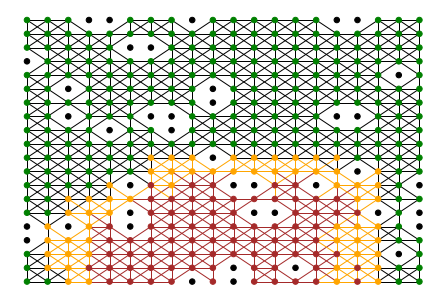

Forest fire simulation complete.
Reached the maximum iteration number.


In [163]:
# parameters to play around
nodes = 400 # number of nodes in the network
scale = 100/nodes # scale to fit into visual
proximity = 1.42*scale # threshold proximity for the fire
density_factor = 0.9 # network dense factor (what percent of the network will have trees); uniform rnd
dist_scale = 30 # for the distance of two nodes
wl = False # whether you want to see labels
pos_dict = {} # dictionary that will hold (K,V) pairs of (node, pos)
# aspect coefficient dictionary
aspect_dict = {'N': -0.063, 'NE':0.349, 'E':0.686, 'SE':0.557, 'S':0.039, 'SW':-0.155, 'W':-0.252, 'NW':-0.171}
ele_series = df[1:nodes]['Elevation'] # get series for Elevation
ele_max = max(ele_series)
ele_min = min(ele_series) # get min and max of elevation
max_speed = 25 # user defined max wind speed possible
epsilon = 0.1 # some small value
lbls={}

g = nx.Graph() # create graph
k = 1 # node name
empty_list = [] # list of nodes that do not have trees
for i in range(1,int(np.sqrt(nodes))+1):
	for j in range(1,int(np.sqrt(nodes))+1):
		slope = df.at[k,'Slope']
		elevation = df.at[k, 'Elevation']
		aspect = df.at[k, 'Aspect']
		theta = node_threshold(slope, elevation, ele_min, ele_max, aspect, aspect_dict)
		lf = rnd.randint(3,7)
		#lf = 6
		if (rnd.uniform(0,1) > density_factor):
			g.add_node(k, threshold_switch = 1.0, color = 'black', num_of_active_neighbors = 0, fire_state = 'empty', life = lf, pos=(i*scale,j*scale))
			empty_list.append(k)
		else:
			g.add_node(k, threshold_switch = theta, color = 'green', num_of_active_neighbors = 0, fire_state = 'not_burnt', life = lf, pos=(i*scale,j*scale))
		pos_dict[k] = (i,j)
		lbls[k] = k
		k += 1

edge_list = [] # contains edge list
for i in range(1,nodes+1):
	for j in range(i,nodes+1):
		if (i == j):
			continue
		p1 = g.nodes[i]['pos']
		p2 = g.nodes[j]['pos']
		# the euclidean distance checks for whether an edge should exist, faraway nodes don't have edges
		# no edges for 'empty' (no forest)
		not_empty = g.nodes[i]['fire_state'] != 'empty' and g.nodes[j]['fire_state'] != 'empty'
		if (dist(p1,p2) < proximity*dist_scale and not_empty): 
			edge_list.append((i,j))

# add edges to the network
for edge in edge_list:
	n1 = edge[0]
	n2 = edge[1]
	ws = 0.01
	p1 = g.nodes[n1]['pos']
	p2 = g.nodes[n2]['pos']
	angle = get_angle(p1,p2)
	pp = edge_weight(max_speed, epsilon, 0, angle, dist(p1,p2))
	lf = np.floor((g.nodes[n1]['life'] + g.nodes[n2]['life'])/2)
	g.add_edge(n1, n2, w=pp, color='black', life=lf, edge_strength=0, wind_speed=ws, wind_dir=angle)
	
edge_colors = nx.get_edge_attributes(g,'color').values()

colors=['green' for i in range(nodes)]
# nodes which don't have trees are colored black
for item in empty_list:
	colors[item-1] = 'black'
# g_temp = copy.deepcopy(g)

# pp_dict = {}
# for item in pos_dict.items():
# 	v = item[1]
# 	k = item[0]
# 	y = v[1]+0.2
# 	x = v[0]+0.2
# 	pp_dict[k] = (x,y)
# g_temp = g
#nx.draw_networkx_labels(g,pp_dict,labels=lbls,font_size=12,font_color='red')

# ========================== Simulations happen below
#print("Ignition Point:  x")
print("Current number of burning forests: ", 0)
print("Timestep  0:")
timesteps_list = [0]
igniting_forests = [0]
burnt_forests = [0]
affected_forests = [0]
node_colors = nx.get_node_attributes(g,'color').values()
#nx.draw(g, node_size=30, node_color=node_colors, edge_color=edge_colors, with_labels=wl, pos=pos_dict, font_size=15)
draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
pos=nx.get_node_attributes(g,'pos')
plt.show()
time.sleep(1)
clear_output(wait=True)

num = g.number_of_nodes()
ignition_node = rnd.randint(1,num+1)
while (g.nodes[ignition_node]['fire_state'] != 'not_burnt'):
	ignition_node = rnd.randint(1,num+1)
g.nodes[ignition_node]['fire_state'] = 'burning'
g.nodes[ignition_node]['color'] = 'orange'
colors[ignition_node-1] = 'orange'

timesteps = 10
prev_burning_forests = 0
current_burning_forests = 1
wind_xy = []
wind_widths = []
wind_heights = []
i = 1
termination = 0

#while (i <= timesteps and prev_burning_forests < current_burning_forests):
while (i <= timesteps):
	#print("Ignition Point: ", ignition_node)
	print("Current number of burning forests: ", current_burning_forests)
	print("Timestep ", i, ":")
	timesteps_list.append(i)
	igniting_forests.append(current_burning_forests)
	burnt_forests.append(count_burnt(g))
	affected_forests.append(current_burning_forests + count_burnt(g))
	#g.nodes[ignition_node]['color'] = 'orange'
	node_colors = nx.get_node_attributes(g,'color').values()
	edge_colors = nx.get_edge_attributes(g,'color').values()
	draw_graph(g, 30, node_colors, edge_colors, pos_dict, 20)
	#nx.draw_networkx_labels(g,pp_dict,labels=lbls,font_size=12,font_color='red')
	plt.show()
	ignite()
	lifeline_update()
	life_edge_update()
	prev_burning_forests = current_burning_forests
	current_burning_forests = count_burning(g)
	if (i%3 == 2):
		wpp = simulate_wind()
		wind_xy.append(wpp[0])
		wind_widths.append(wpp[1])
		wind_heights.append(wpp[2])
	if (i == timesteps or prev_burning_forests >= current_burning_forests):
		termination = int(prev_burning_forests >= current_burning_forests)
		break
# 	if (i == timesteps):
# 		break
#	time.sleep(2)
	clear_output(wait=True)
	i += 1

print("Forest fire simulation complete.")
msg = "No new forests are burning." if termination else "Reached the maximum iteration number."
print(msg)

### IGNORE BELOW

In [158]:
# g = copy.deepcopy(g_temp)
# sc=2
# for node in [n for n in g.nodes()]:
# 	nt = g.nodes[node]['threshold_switch']
# 	bs = np.tan(np.pi*(nt-0.5))*sc
# 	nwt = np.arctan(bs)/np.pi + 0.5
# 	g.nodes[node]['threshold_switch'] = nwt

### Run some test and analyses (Ignore)

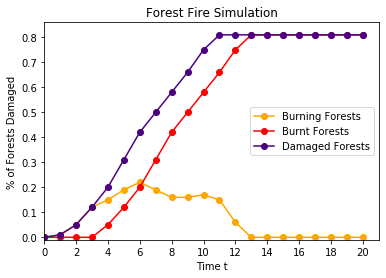

In [19]:
if igniting_forests[1] >= 1:
	igniting_forests = [n*0.01 for n in igniting_forests]
	burnt_forests = [n*0.01 for n in burnt_forests]
	affected_forests = [n*0.01 for n in affected_forests]
plt_list(l=[timesteps_list, igniting_forests, burnt_forests, affected_forests], markers=['o', 'o', 'o'],
		 colors=['orange', 'red', 'indigo'], axes_range=[0, max(timesteps_list)+1,
														-0.01, get_max_of_max([igniting_forests, burnt_forests, affected_forests])+0.05],
		 steps=[2,1], title="Forest Fire Simulation",
		 xlabel="Time t", ylabel="% of Forests Damaged", legend_pos="center right",
		labels=['Burning Forests', 'Burnt Forests', 'Damaged Forests'])

In [166]:
affected_d_05 = affected_forests

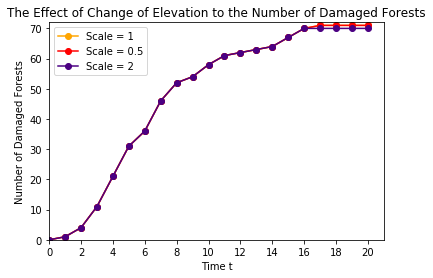

In [151]:
plt_list(l=[timesteps_list, affected_1, affected_2, affected_3], markers=['o', 'o', 'o'],
		 colors=['orange', 'red', 'indigo'], axes_range=[0, max(timesteps_list)+1,
														0, get_max_of_max([affected_1, affected_2, affected_3])+1],
		 steps=[2,1], title="The Effect of Change of Elevation to the Number of Damaged Forests",
		 xlabel="Time t", ylabel="Number of Damaged Forests", legend_pos="upper left",
		labels=['Scale = 1', 'Scale = 0.5', 'Scale = 2'])

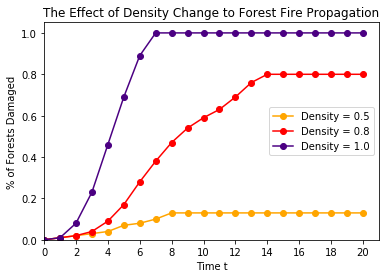

In [183]:
plt_list(l=[timesteps_list, affected_d_05, affected_d_08, affected_d_10], markers=['o', 'o', 'o'],
		 colors=['orange', 'red', 'indigo'], axes_range=[0, max(timesteps_list)+1,
														0, get_max_of_max([affected_d_05, affected_d_08, affected_d_10])+0.051],
		 steps=[2,1], title="The Effect of Density Change to Forest Fire Propagation",
		 xlabel="Time t", ylabel="% of Forests Damaged", legend_pos="best",
		labels=['Density = 0.5', 'Density = 0.8', 'Density = 1.0'])

In [174]:
#affected_d_05 = [n*0.01 for n in affected_d_05]
affected_d_08 = [n*0.01 for n in affected_d_08]
affected_d_10 = [n*0.01 for n in affected_d_10]
